##Data preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#Load locally stored csv with data from yahoo (BTC-USD since 9/14/2014):

In [8]:
path = os.getcwd() 
initial_data = pd.read_csv(path + "/exper_files/datasets/BTC-USD_yahoo.csv")

Convert 'Date' column to type 'datetime64'

In [9]:
initial_data['Date'] = pd.to_datetime(initial_data['Date'])

Some values are null, so lets fill them with the values of the previous day:

In [10]:
initial_data.fillna(method='ffill', inplace=True)

Set 'Date' as index of DataFrame:

In [16]:
initial_data = initial_data.set_index("Date")

Split data into training and test set. Next, scale them without a sliding window: 

In [72]:
#Splitting

percent_train_set = 0.75
split_date = initial_data.iloc[round(initial_data.shape[0] * percent_train_set)]
split_date = pd.to_datetime(split_date.name)

training_set, val_test_set = initial_data[initial_data.index < split_date], \
                             initial_data[initial_data.index >= split_date]

percent_val_set = 0.5
split_date_val = val_test_set.iloc[round(val_test_set.shape[0] * percent_val_set)]
split_date_val = pd.to_datetime(split_date_val.name)

val_set, test_set = val_test_set[val_test_set.index < split_date_val], \
                    val_test_set[val_test_set.index >= split_date_val]


#Scaling

scaler = MinMaxScaler(feature_range=(0, 1)) #Scaler for all columns

train_scaled_data = pd.DataFrame(scaler.fit_transform(training_set.values), columns=training_set.columns, 
                                 index=training_set.index) #Training set fit and transform

close_scaler = MinMaxScaler(feature_range=(0, 1)) #Scaler for 'Close' column only
close_scaler.fit((training_set['Close'].values).reshape(-1, 1)) #Training set fit only to 'Close' values

val_scaled_data = pd.DataFrame(scaler.transform(val_set.values), columns=val_set.columns,
                              index=val_set.index) #Validation set just transform

test_scaled_data = pd.DataFrame(scaler.transform(test_set.values), columns=test_set.columns,
                               index=test_set.index) #Test set just tranform


#Transform the data into the appropriate form

pred_range = 5 #The number of days-ahead for which each prediction will be performed
window_len = 10 #The number of days inserted in LSTM as a single input

#Create LSTM inputs for training
LSTM_training_inputs = []
for i in range(len(train_scaled_data) - window_len):
    temp_set = train_scaled_data[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Open'], axis=1)
    temp_set = temp_set.drop(['High'], axis=1)
    temp_set = temp_set.drop(['Low'], axis=1)
    temp_set = temp_set.drop(['Adj Close'], axis=1)

    LSTM_training_inputs.append(temp_set)

#Create LSTM outputs for training. Each output is corresponded to the days which are going to be predicted (pred_range)   
LSTM_ranged_training_outputs = []
for i in range(window_len, len(train_scaled_data['Close']) - pred_range):
    LSTM_ranged_training_outputs.append(train_scaled_data['Close'][i:i+pred_range].values)

LSTM_ranged_training_outputs = np.array(LSTM_ranged_training_outputs)


#Create LSTM inputs for validation
LSTM_val_inputs=[]
for i in range(len(val_scaled_data) - window_len):
    temp_set = val_scaled_data[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Open'], axis=1)
    temp_set = temp_set.drop(['High'], axis=1)
    temp_set = temp_set.drop(['Low'], axis=1)
    temp_set = temp_set.drop(['Adj Close'], axis=1)
    
    LSTM_val_inputs.append(temp_set)

#Create LSTM outputs for validation. Each output is corresponded to the days which are going to be predicted (pred_range)   
LSTM_ranged_val_outputs = []
for i in range(window_len, len(val_scaled_data['Close']) - pred_range):
    LSTM_ranged_val_outputs.append(val_scaled_data['Close'][i:i+pred_range].values)

LSTM_ranged_val_outputs = np.array(LSTM_ranged_val_outputs)


#Create LSTM inputs for testing
LSTM_test_inputs = []
for i in range(len(test_scaled_data) - window_len):
    temp_set = test_scaled_data[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Open'], axis=1)
    temp_set = temp_set.drop(['High'], axis=1)
    temp_set = temp_set.drop(['Low'], axis=1)
    temp_set = temp_set.drop(['Adj Close'], axis=1)
    
    LSTM_test_inputs.append(temp_set)

Convert DataFrames to numpy arrays

In [73]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_val_inputs = [np.array(LSTM_val_input) for LSTM_val_input in LSTM_val_inputs]
LSTM_val_inputs = np.array(LSTM_val_inputs)

LSTM_test_inputs = [np.array(LSTM_test_input) for LSTM_test_input in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

##Define LSTM model

In [60]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf


def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
   
    
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Build the model

In [61]:
neurons = 50

ranged_btcoin_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons=neurons)

Train the model

In [62]:
np.random.seed(202)

epochs = 100
batch_size = 64

ranged_hist = ranged_btcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs,
                                       validation_data=(LSTM_val_inputs[:-pred_range], LSTM_ranged_val_outputs), epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True, workers=8)


Epoch 1/100
29/29 - 4s - loss: 0.1002 - val_loss: 0.1873
Epoch 2/100
29/29 - 0s - loss: 0.0389 - val_loss: 0.0469
Epoch 3/100
29/29 - 0s - loss: 0.0303 - val_loss: 0.0424
Epoch 4/100
29/29 - 0s - loss: 0.0275 - val_loss: 0.0302
Epoch 5/100
29/29 - 0s - loss: 0.0260 - val_loss: 0.0262
Epoch 6/100
29/29 - 0s - loss: 0.0251 - val_loss: 0.0280
Epoch 7/100
29/29 - 0s - loss: 0.0242 - val_loss: 0.0330
Epoch 8/100
29/29 - 0s - loss: 0.0235 - val_loss: 0.0259
Epoch 9/100
29/29 - 0s - loss: 0.0231 - val_loss: 0.0242
Epoch 10/100
29/29 - 0s - loss: 0.0227 - val_loss: 0.0239
Epoch 11/100
29/29 - 0s - loss: 0.0227 - val_loss: 0.0318
Epoch 12/100
29/29 - 0s - loss: 0.0225 - val_loss: 0.0251
Epoch 13/100
29/29 - 0s - loss: 0.0217 - val_loss: 0.0254
Epoch 14/100
29/29 - 0s - loss: 0.0217 - val_loss: 0.0268
Epoch 15/100
29/29 - 0s - loss: 0.0212 - val_loss: 0.0274
Epoch 16/100
29/29 - 0s - loss: 0.0205 - val_loss: 0.0286
Epoch 17/100
29/29 - 0s - loss: 0.0207 - val_loss: 0.0242
Epoch 18/100
29/29 - 0s

Plot MAE:

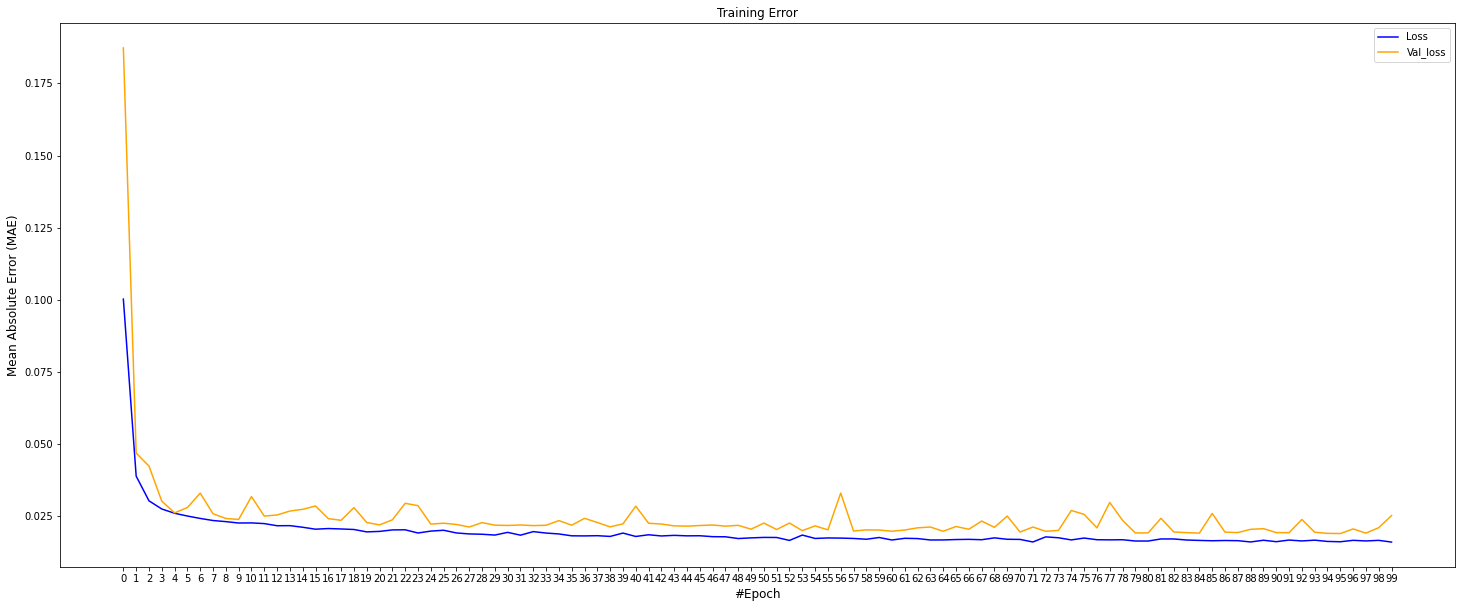

In [63]:
fig, ax1 = plt.subplots(1, 1, figsize=(25, 10))

ax1.plot(ranged_hist.epoch, ranged_hist.history['loss'], color='b', label='Loss')
ax1.plot(ranged_hist.epoch, ranged_hist.history['val_loss'], color='orange', label='Val_loss')
ax1.set_xticks(range(0, len(ranged_hist.epoch)))
ax1.set_title('Training Error')
ax1.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax1.set_xlabel('#Epoch', fontsize=12)
plt.legend()
plt.show()

#Get predictions and reformat array

In [97]:
pred_prices = ranged_btcoin_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range] #Normalized predictions
pred_prices_shape = pred_prices.shape
normalized_pred_prices = (pred_prices.copy()).reshape(-1)
pred_prices = pred_prices.reshape(-1, 1)

#Apply inverse transformation
pred_prices = close_scaler.inverse_transform(pred_prices)
pred_prices = pred_prices.reshape(pred_prices_shape)

#Plot predictions side-by-side with actual values

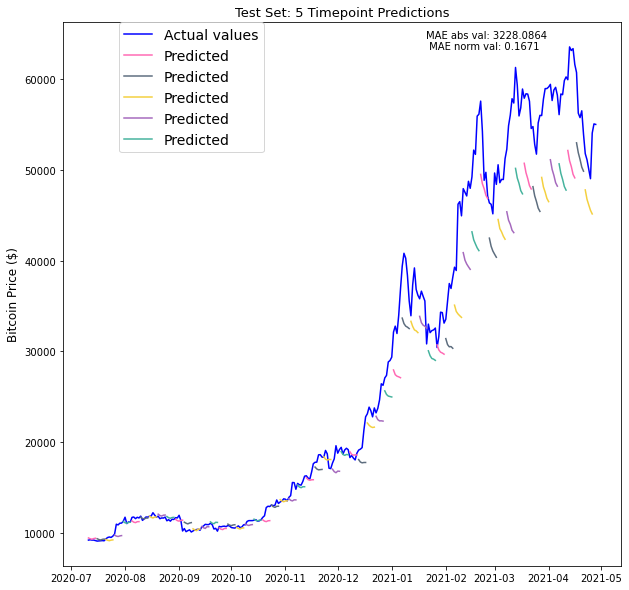

In [109]:
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F", "#A569BD", "#45B39D"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

ax1.plot((initial_data[initial_data.index >= split_date_val][window_len:]).index,
         test_set['Close'][window_len:], label='Actual values', color='b')

for i, pred in enumerate(pred_prices):

    if i < pred_range: #Print label=predicted for the first time

        ax1.plot(((initial_data[initial_data.index >= split_date_val][window_len:]).index)[
                 (i * pred_range):((i * pred_range) + pred_range)],
                 pred, color=pred_colors[i % pred_range], label='Predicted')

    else: #Dont print label=predicted again

        ax1.plot(((initial_data[initial_data.index >= split_date_val][window_len:]).index)[
                 (i * pred_range):((i * pred_range) + pred_range)],
                 pred, color=pred_colors[i % pred_range])

ax1.set_title('Test Set: 5 Timepoint Predictions', fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})

ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})

res = ((len(test_set['Close'].values[window_len:])-window_len)%pred_range)
test_set_len = len(test_set['Close'])


MAE_norm_val = np.mean( np.abs(normalized_pred_prices - (test_scaled_data['Close'].values[window_len:(test_set_len-res)])))

MAE_abs_val = np.mean(np.abs((pred_prices.reshape(-1)) - (test_set['Close'].values[window_len:test_set_len-res])))


ax1.annotate('MAE abs val: %.4f \n MAE norm val: %.4f' % (MAE_abs_val, MAE_norm_val),
             xy=(0.65, 0.95), xycoords='axes fraction',
             xytext=(0.65, 0.95), textcoords='axes fraction')
plt.show()